### <font color = 'darkgreen'> **Packages** </font>

In [2]:
from MCEq.core import config, MCEqRun
import crflux.models as crf
import matplotlib.pyplot as plt
import scipy
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages

### <font color = 'darkgreen'> **Functions** </font>

<font color = 'black'> ***frac_mu**(energy, particle, month, energy_threshold, interaction = 'SIBYLL23C', integrate = False)*</font>


Returns the fraction of detected muons from kaons, pions, and other sources in either an energy spectrum or a single number.
* energy: the primary energy of the particle in GeV; type:int
* particle: indicates the type of primary particle in the cosmic air shower; type:str
    * eg. Proton ('p') or iron ('fe')
* energy_threshold: lower energy limit used for integration purposes in GeV; type:int
    * Default: 500 (Units of GeV)
* month: the month in which the cosmic air shower occurs; type:str
* interaction: the hadronic interaction model used for MCEq
    * Eg. 'SIBYLL23C' (default), 'QGSJet-II-04', 'EPOS-LHC'
* integrate: option to integrate the energy spectrum to obtain a single value for the number of muons from a source
    * Options: False (default), True



<font color = 'black'>***sfit**(x, amplitude, freq, phase, offset)*</font>


Returns a sinusoidal curve fitting for a set of data points.
* x: the data points considered for fitting
* amplitude: the estimated amplitude of the curve
* freq: the estimated amplitude of the curve
* phase: the estimated horizontal shift of the curve from the origin
* offset: the estimated vertical shift of the curve from the origin 


In [3]:
def frac_mu(energy:int, particle: str, month: str, energy_threshold = 500, interaction = 'SIBYLL23C', integrate = False):
    mceq = MCEqRun(
    interaction_model = interaction, # High-energy hadronic interaction model
    primary_model = (crf.HillasGaisser2012, 'H3a'),   # cosmic ray flux at the top of the atmosphere
    theta_deg = 0.  # zenith angle - 0 indicates vertical airshower
    )

    if particle == 'p':
        mceq.set_single_primary_particle(energy, pdg_id=2212) # energies are in units of GeV

    elif particle == 'fe':
        mceq.set_single_primary_particle(energy, corsika_id = 5626) # energies are in units of GeV
    
    h_grid = np.linspace(50 * 1e3 * 1e2, 283500) # altitudes up until observation level of IceCube (in cm)
    X_grid = mceq.density_model.h2X(h_grid)
    mceq.set_density_model(('MSIS00_IC', ('SouthPole', month)))
    
    mceq.solve(int_grid = X_grid)
    
    # The following variables are arrays of the spectrum as a function of energy
    mu_tot = mceq.get_solution('total_mu+') + mceq.get_solution('total_mu-')
    mu_pi= mceq.get_solution('pi_mu+') + mceq.get_solution('pi_mu-')
    mu_k = mceq.get_solution('k_mu+') + mceq.get_solution('k_mu-')
    mu_prompt = mceq.get_solution('pr_mu+') + mceq.get_solution('pr_mu-')

    E = mceq.e_grid
    
    if integrate == True:
        # following code from Stef
        spline_tot = scipy.interpolate.CubicSpline(E, mu_tot)
        spline_pi = scipy.interpolate.CubicSpline(E, mu_pi)
        spline_k = scipy.interpolate.CubicSpline(E, mu_k)
        spline_other = scipy.interpolate.CubicSpline(E, mu_prompt)

        # The following code will return the value AND the uncertainty  
        # Since we only want the value, we only take the first index
        tot_mu = scipy.integrate.quad(lambda x : spline_tot(x), energy_threshold, 1e5)
        tot_pi_mu = scipy.integrate.quad(lambda x : spline_pi(x), energy_threshold, 1e5)
        tot_k_mu = scipy.integrate.quad(lambda x : spline_k(x), energy_threshold, 1e5)
        tot_mu_other = scipy.integrate.quad(lambda x : spline_other(x), energy_threshold, 1e5)

        return tot_mu[0], tot_pi_mu[0], tot_k_mu[0], tot_mu_other[0]
    
    return E, mu_tot, mu_pi, mu_k, mu_prompt

#############
def sfit(x, amplitude, frequency, phase, offset):
        return amplitude * np.sin(frequency * x + phase) + offset

In [ ]:
## Function for the fraction of muons from pions, kaons, and other (prompt)
def frac_in_mu(energy:int, particle: str, month: str, interaction = 'SIBYLL23C', integrate = False):
    mceq = MCEqRun(
    interaction_model = interaction, # High-energy hadronic interaction model
    primary_model = (crf.HillasGaisser2012, 'H3a'),   # cosmic ray flux at the top of the atmosphere
    theta_deg = 0.  # zenith angle - 0 indicates vertical airshower
    )

    if particle == 'p':
        mceq.set_single_primary_particle(energy, pdg_id=2212) # energies are in units of GeV

    elif particle == 'fe':
        mceq.set_single_primary_particle(energy, corsika_id = 5626) # energies are in units of GeV
    
    h_grid = np.linspace(50 * 1e3 * 1e2, 283500) # altitudes up until observation level of IceCube (in cm)
    X_grid = mceq.density_model.h2X(h_grid)
    mceq.set_density_model(('MSIS00_IC', ('SouthPole', month)))
    
    mceq.solve(int_grid = X_grid)
    
    mu_total = mceq.get_solution('total_mu+') + mceq.get_solution('total_mu-')
    mu_pi = mceq.get_solution('pi_mu+') + mceq.get_solution('pi_mu-')
    mu_k = mceq.get_solution('k_mu+') + mceq.get_solution('k_mu-')
    mu_prompt  = mceq.get_solution('pr_mu+') + mceq.get_solution('pr_mu-')
    E = mceq.e_grid

    return E, mu_total, mu_pi, mu_k, mu_prompt


#################################################
## Function for number of muons from sources
def tot_muons_frac(energy:int, particle: str, month: str, energy_threshold:int, interaction = 'SIBYLL23C'):
    mceq = MCEqRun(
    interaction_model = interaction, # High-energy hadronic interaction model
    primary_model = (crf.HillasGaisser2012, 'H3a'),   # cosmic ray flux at the top of the atmosphere
    theta_deg = 0.  # zenith angle - 0 indicates vertical airshower
    )

    if particle == 'p':
        mceq.set_single_primary_particle(energy, pdg_id=2212) # energies are in units of GeV

    elif particle == 'fe':
        mceq.set_single_primary_particle(energy, corsika_id = 5626) # energies are in units of GeV
    
    h_grid = np.linspace(50 * 1e3 * 1e2, 283500) # altitudes up until observation level of IceCube (in cm)
    X_grid = mceq.density_model.h2X(h_grid)
    mceq.set_density_model(('MSIS00_IC', ('SouthPole', month)))
    
    mceq.solve(int_grid = X_grid)
    
    mu_total_arr = mceq.get_solution('total_mu+') + mceq.get_solution('total_mu-')
    mu_pi_arr = mceq.get_solution('pi_mu+') + mceq.get_solution('pi_mu-')
    mu_k_arr = mceq.get_solution('k_mu+') + mceq.get_solution('k_mu-')
    mu_prompt = mceq.get_solution('pr_mu+') + mceq.get_solution('pr_mu-')

    E = mceq.e_grid

    # following code from Stef
    spline_tot = scipy.interpolate.CubicSpline(E, mu_total_arr)
    spline_pi = scipy.interpolate.CubicSpline(E, mu_pi_arr)
    spline_k = scipy.interpolate.CubicSpline(E, mu_k_arr)
    spline_other = scipy.interpolate.CubicSpline(E, mu_prompt)

    # The following code will return the value AND the uncertainty -- since we only want the value, I will only take the first index
    tot_mu = scipy.integrate.quad(lambda x : spline_tot(x), energy_threshold, 1e5)
    tot_pi_mu = scipy.integrate.quad(lambda x : spline_pi(x), energy_threshold, 1e5)
    tot_k_mu = scipy.integrate.quad(lambda x : spline_k(x), energy_threshold, 1e5)
    tot_mu_other = scipy.integrate.quad(lambda x : spline_other(x), energy_threshold, 1e5)

    
    return tot_mu[0], tot_pi_mu[0], tot_k_mu[0], tot_mu_other[0]

#################################################
## Sinusoid fitting function
def sfit(x, amplitude, frequency, phase, offset):
        return amplitude * np.sin(frequency * x + phase) + offset

### <font color = 'darkred'> **Monthly Variations > 500 GeV** </font>

**Goal**: Show how the **number of muons > 500 GeV** in a shower varies per month.

Results will be saved to text files then used in plots for future use.

In [4]:
energies = [1, 3, 10, 30, 100, 300, 1000] # energy of primary particle
thres_list = [1, 10, 100, 500, 1000] # threshold energies
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'Average'] 

In [ ]:
## Making text files for the contributions - for 500 GeV
thres = 500 
for particle in ['p', 'fe']:
    for energy in [300]:
        ## Creating arrays with the length of the energy spectrum (121 indices)
        p_mu_sum = np.zeros(121)
        p_pi_sum = np.zeros(121)
        p_k_sum = np.zeros(121)
        p_other_sum = np.zeros(121)
        
        fe_mu_sum = np.zeros(121)
        fe_pi_sum = np.zeros(121)
        fe_k_sum = np.zeros(121)
        fe_other_sum = np.zeros(121)
        
        for m in months:
            if (m != 'Average'):  # proceed if it is a month
                model = 'QGSJet-II-04' # interaction model - may vary
                E, muon, mu_pi, mu_k, mu_prompt = frac_mu(energy*(1e6), particle, m, thres, model, integrate = False) 
                if particle == 'p':
                    for k in range(121):
                        p_mu_sum[k] = muon[k]
                        p_pi_sum[k] = mu_pi[k] 
                        p_k_sum[k] =  mu_k[k] 
                        p_other_sum[k] = mu_prompt[k] 
                    np.savetxt('C:/Users/catal/IceCube Research/'+ model+ '/Muon_Sources/Proton/'+ str(energy) + 'PeV/' + m +'_'+ str(energy)+ 'PeV.txt', 
                               np.column_stack([E, muon, mu_pi, mu_k, mu_prompt]), 
                               header="Emu(GeV)\tdNdE(1/GeV)\tdN_mu_pions(1/GeV)\tdN_mu_kaons(1/GeV)\tdN_mu_other(1/GeV)")
                    
                if particle == 'fe':
                    for k in range(121):
                        fe_mu_sum[k] = muon[k]
                        fe_pi_sum[k] = mu_pi[k] 
                        fe_k_sum[k] = mu_k[k] 
                        fe_other_sum[k] = mu_prompt[k] 

                    np.savetxt('C:/Users/catal/IceCube Research/' + model + '/Muon_Sources/'+ str(particle)+ '/' + str(energy) +'PeV/' + m +'_' +str(energy) + 'PeV.txt', 
                               np.column_stack([E, muon, mu_pi, mu_k, mu_prompt]), 
                               header="Emu(GeV)\tdNdE(1/GeV)\tdN_mu_pions(1/GeV)\tdN_mu_kaons(1/GeV)\tdN_mu_other(1/GeV)")

            if (m == 'Average'):
                if particle == 'p':
                    p_mu_avg = p_mu_sum/12
                    p_pi_avg = p_pi_sum/12
                    p_k_avg = p_k_sum/12 
                    p_other_avg = p_other_sum/12

                    np.savetxt('C:/Users/catal/IceCube Research/' + model+ '/Muon_Sources/Proton/' + str(energy) + 'PeV/'+ m + '_' + str(energy)+'PeV.txt', 
                               np.column_stack([E, muon, mu_pi, mu_k, mu_prompt]), 
                               header="Emu(GeV)\tdNdE(1/GeV)\tdN_mu_pions(1/GeV)\tdN_mu_kaons(1/GeV)\tdN_mu_other(1/GeV)\tdN_mu_prompt(1/GeV)")
           
                if particle == 'fe':
                    fe_mu_avg = fe_mu_sum/12
                    fe_pi_avg = fe_pi_sum/12
                    fe_k_avg = fe_k_sum/12 
                    fe_other_avg = fe_other_sum/12

                    np.savetxt('C:/Users/catal/IceCube Research/' +model+ '/Muon_Sources/Fe/' + str(energy) + 'PeV/'+ m + '_' + str(energy)+'PeV.txt', 
                               np.column_stack([E, muon, mu_pi, mu_k, mu_prompt]), 
                               header="Emu(GeV)\tdNdE(1/GeV)\tdN_mu_pions(1/GeV)\tdN_mu_kaons(1/GeV)\tdN_mu_other(1/GeV)\tdN_mu_prompt(1/GeV)")

In [ ]:
## Comparing different energy thresholds for seasonal variations 
for energy_thres in [500]: #units of GeV
    for particle in ['p', 'fe']: 
        model_list = ['SIBYLL23C', 'EPOS-LHC','QGSJet-II-04'] 
        for model in model_list:
            energy = 300   # primary energy, units of PeV 
            tot_list = []
            pi_list = []
            k_list = []
            prompt_list = []
            
            for i in range(12):
                m = months[i]  # only averages over the months
                tot_mu, mu_pi, mu_k, mu_other = frac_mu(energy*(1e6), particle, m, energy_thres, model, integrate = True)
                tot_list.append(tot_mu)
                pi_list.append(mu_pi)
                k_list.append(mu_k)
                prompt_list.append(mu_other)

            np.savetxt('C:/Users/catal/IceCube Research/' + model + '/Diff_Seasonal_Var/'+ str(energy) + 'PeV/' + particle.capitalize() +'_Sums_' + str(energy_thres) + 'GeV.txt', 
                       np.column_stack([tot_list, pi_list, k_list, prompt_list]), header="Total_Muons\tFrom_Pions\tFrom_Kaons\tFrom_Other_Sources");

MCEqRun::set_interaction_model(): EPOSLHC
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('SouthPole', 'January')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle =  0.00
MCEqRun::set_interaction_model(): EPOSLHC
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('SouthPole', 'February')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle =  0.00
MCEqRun::set_interaction_model(): EPOSLHC
ParticleManager::_init_default_tracking(): Initializing default tra

###  <font color = 'darkred'> **Variations for a 10 PeV Proton w/ 500 GeV Energy Threshold -  SIBYLL23C** </font>

In [6]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
months_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

#### Fitted Curve for Total Number of Muons from Sources

In [ ]:
## Loading text file for 10 PeV proton
tot_mu, mu_pi, mu_k, mu_other = np.loadtxt('C:/Users/catal/IceCube Research/SIBYLL23C/Muon_Sources\{}\{}PeV\Sums2.txt'.format('Proton', 10, 10), unpack=True)
mu_avg = sum(tot_mu)/12 # yearly average for total number of muons
mu_pi_avg = sum(mu_pi)/12
mu_k_avg = sum(mu_k)/12
mu_other_avg = sum(mu_other)/12

C:\Users\catal\AppData\Local\Temp\ipykernel_17876\2467929016.py:20: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x_fit, y_fit, '-', label='Fitted Curve', ls = '--', color = 'r')


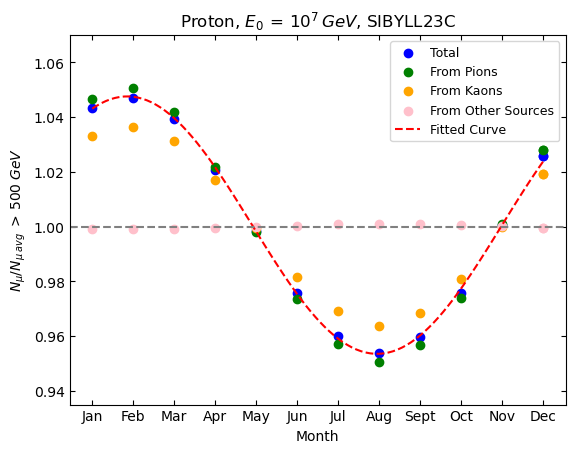

In [15]:
fig, ax = plt.subplots()
for i in range(len(months)):
    
    plt.scatter(i, tot_mu[i]/mu_avg, c = 'b')
    plt.scatter(i, mu_pi[i]/mu_pi_avg, color = 'green')
    plt.scatter(i, mu_k[i]/mu_k_avg, color = 'orange')
    plt.scatter(i, mu_other[i]/mu_other_avg, color = 'pink')

    if i == 11: 
        plt.scatter(i, tot_mu[i]/mu_avg, c = 'b', label = 'Total')
        plt.scatter(i, mu_pi[i]/mu_pi_avg, color = 'green', label = 'From Pions')
        plt.scatter(i, mu_k[i]/mu_k_avg, color = 'orange', label = 'From Kaons')
        plt.scatter(i, mu_other[i]/mu_other_avg, color = 'pink', label = 'From Other Sources') 

## Fitting
popt, pcov = curve_fit(sfit, [0,1,2,3,4,5,6,7,8,9,10,11], tot_mu/mu_avg, p0=[0.06, 1/6, 1, 1])
amplitude_fit, frequency_fit, phase_fit, offset_fit = popt
x_fit = np.linspace(0, 11, 100)
y_fit = sfit(x_fit, amplitude_fit, frequency_fit, phase_fit, offset_fit)
plt.plot(x_fit, y_fit, '-', label='Fitted Curve', ls = '--', color = 'r')

###
plt.axhline(y=1, color='grey', linestyle='--')
ax.tick_params(top=True, bottom=True, left=True, right=True, direction='in')
plt.ylim(0.935, 1.07)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], months_label)
plt.xlabel('Month')
plt.ylabel('$N_\mu / N_{\mu \; avg} \; > \, 500 \; GeV$')
plt.title('Proton, ' + '$E_0 \,=\, 10^7 \, GeV$' + ', SIBYLL23C')
plt.legend(fontsize = 9)

#### Fitted Curve for Total Number of Muons

[0.04701314 0.51545287 1.13070251 1.00055116]


C:\Users\catal\AppData\Local\Temp\ipykernel_17876\1206431108.py:14: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x_fit, y_fit, '-', label='$f(x)\; =\;{:0.2f}\,sin({:0.2f}\,x + {:0.2f}) + {:0.1f}$'.format(amplitude_fit, frequency_fit, phase_fit, offset_fit), ls = '--', color = 'black')


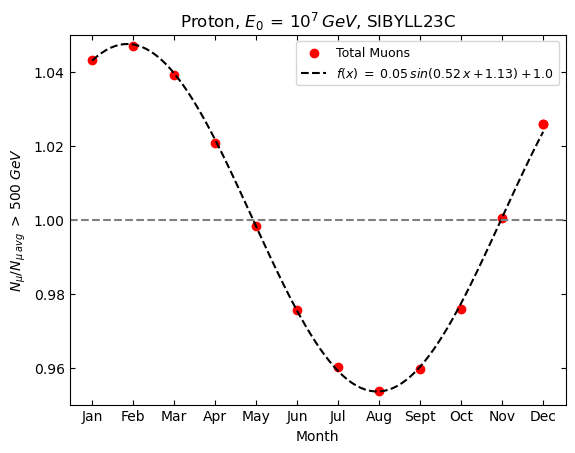

In [16]:
## Plot for relative variations with only total number of muons
fig, ax = plt.subplots()
for i in range(len(months)):
    plt.scatter(i, tot_mu[i]/mu_avg, c = 'r')
    if i == 11: 
        plt.scatter(i, tot_mu[i]/mu_avg, c = 'r', label = 'Total Muons') 

## Fitting
popt, pcov = curve_fit(sfit, [0,1,2,3,4,5,6,7,8,9,10,11], tot_mu/mu_avg, p0=[0.06, 1/6, 1, 1])
print(popt)
amplitude_fit, frequency_fit, phase_fit, offset_fit = popt
x_fit = np.linspace(0, 11, 100)
y_fit = sfit(x_fit, amplitude_fit, frequency_fit, phase_fit, offset_fit)
plt.plot(x_fit, y_fit, '-', label='$f(x)\; =\;{:0.2f}\,sin({:0.2f}\,x + {:0.2f}) + {:0.1f}$'.format(amplitude_fit, frequency_fit, phase_fit, offset_fit), ls = '--', color = 'black')

###
plt.axhline(y=1, color='grey', linestyle='--')
#plt.legend()
ax.tick_params(top=True, bottom=True, left=True, right=True, direction='in')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], months_label)
plt.ylim(0.95, 1.05)
plt.xlabel('Month')
plt.ylabel('$N_\mu / N_{\mu \; avg} \; > \, 500 \; GeV$')
plt.title('Proton, ' + '$E_0 \,=\, 10^7 \, GeV$' + ', SIBYLL23C')
plt.legend(fontsize = 9)

### <font color = 'darkred'> **Relative Variation as a Function of Primary Energy** </font>

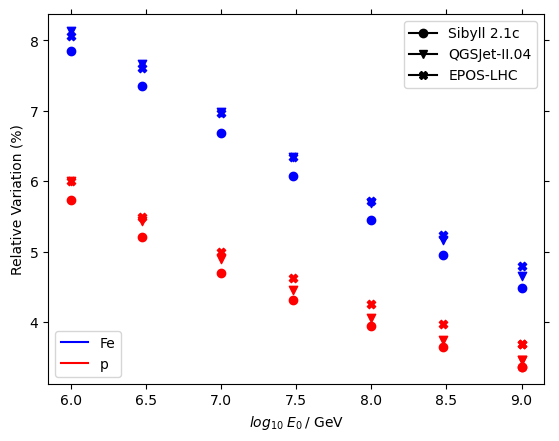

In [15]:
# Primary energies of 1 PeV, 3 PeV, 10 PeV, 100 PeV, 1000 PeV
energy_list = [1, 3, 10, 30, 100, 300, 1000] #PeV add 1000 PeV later
for model in ['SIBYLL23C', 'EPOS-LHC', 'QGSJet-II-04']:
    for particle in ['p', 'fe']:
        for j in energy_list:
            if particle == 'p':
                name = 'P'
                color = 'red'
            elif particle =='fe':
                name = 'Fe'
                color = 'blue'
            tot_mu, mu_pi, mu_k, mu_other = np.loadtxt('C:/Users/catal/IceCube Research/{}\Diff_Seasonal_Var/{}PeV\{}_Sums_500GeV.txt'.format(model, j, name), 
                                                           unpack=True)
            mu_avg = sum(tot_mu)/12 # yearly average for total number of muons
            mu_pi_avg = sum(mu_pi)/12
            mu_k_avg = sum(mu_k)/12
            mu_other_avg = sum(mu_other)/12
    
            ## Fitting
            popt, pcov = curve_fit(sfit, [0,1,2,3,4,5,6,7,8,9,10,11], 
                                tot_mu/mu_avg, p0=[0.05, 1/4, 1, 1])
            amplitude_fit, frequency_fit, phase_fit, offset_fit = popt
            x_fit =[1,10,100,1000]
            #y_fit = sinusoidal_function(x_fit, amplitude_fit, 
            # frequency_fit, phase_fit, offset_fit)
            if model == 'SIBYLL23C':
                marker = 'o'
                plt.scatter(np.log10(j) + 6, abs(100*amplitude_fit), marker = marker, color = color)
                if j == 1000 and particle =='p':
                    plt.scatter(np.log10(j)+6, abs(100*amplitude_fit), label = model, 
                                marker = marker, color = color)
            if model == 'EPOS-LHC':
                marker = 'v'
                plt.scatter(np.log10(j) + 6, abs(100*amplitude_fit), marker = marker, color = color)
                if j == 1000 and particle =='p':
                    plt.scatter(np.log10(j)+6, abs(100*amplitude_fit), label = model, 
                                marker = marker, color = color)
            if model == 'QGSJet-II-04':
                marker = 'X'
                plt.scatter(np.log10(j)+ 6, abs(100*amplitude_fit), marker = marker, color = color)
                if j == 1000 and particle =='p':
                    plt.scatter(np.log10(j)+6, abs(100*amplitude_fit), label = model, 
                                marker = marker, color = color)
            
            #plt.plot(x_fit, y_fit, '-', label='$f(x)\; =\;{:0.2f}\,sin({:0.2f}\,x + {:0.2f}) + {:0.1f}$'.format(amplitude_fit, frequency_fit, phase_fit, offset_fit), ls = '--', color = 'black')

plt.xlabel(r'$log_{10} \;E_0\, /$' + ' GeV') #primary energy -- energy threshold above 100 GeV
plt.ylabel('Relative Variation (%)')
plt.tick_params(top=True, right=True)
#plt.legend()


marker = {
    'sibyll': 'o',
    'epos': 'v',
    'qgsjet': 'X',
}

plots = [plt.plot([],[],color='k',marker=marker[model])[0] for model in marker.keys()]
model_legend = plt.legend(plots, ['Sibyll 2.1c', 'QGSJet-II.04', 'EPOS-LHC'], loc='upper right')
plots = [plt.plot([],[],color=c,linestyle='-')[0] for c in ['b','r']]
primary_legend = plt.legend(plots, ['Fe','p'], loc='lower left')
plt.gca().add_artist(model_legend)

plt.show()

### <font color = 'darkred'> **Creating PDFs** </font>

#### SIBYLL23C Sinusoidal Fittings

[0.05202267 0.51584129 1.15760146 1.00059575]
[0.04701314 0.51545287 1.13070251 1.00055116]


C:\Users\catal\AppData\Local\Temp\ipykernel_21500\2766397317.py:23: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x_fit, y_fit, '-', label='$f(x)\; =\;{:0.2f}\,sin({:0.2f}\,x + {:0.2f}) + {:0.1f}$'.format(amplitude_fit, frequency_fit, phase_fit, offset_fit), ls = '--', color = 'black')


[0.04309927 0.51514949 1.11331998 1.00051504]
[0.03938858 0.51489914 1.10103185 1.00047844]
[0.07357201 0.51695815 1.29321204 1.00080132]
[0.06685921 0.51670388 1.2498329  1.00073369]
[0.06066999 0.51640533 1.2104098  1.00067399]
[0.05442901 0.51601528 1.1717876  1.00061711]


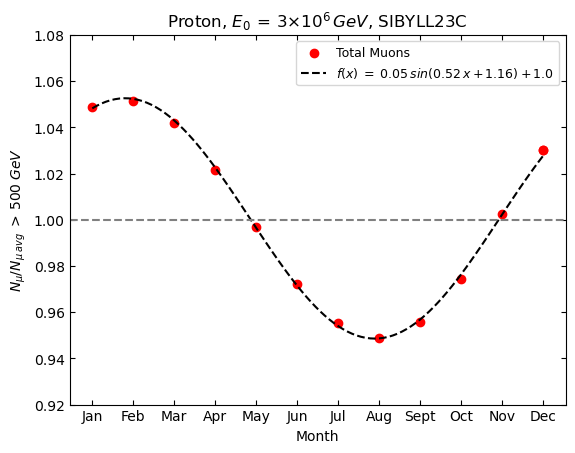

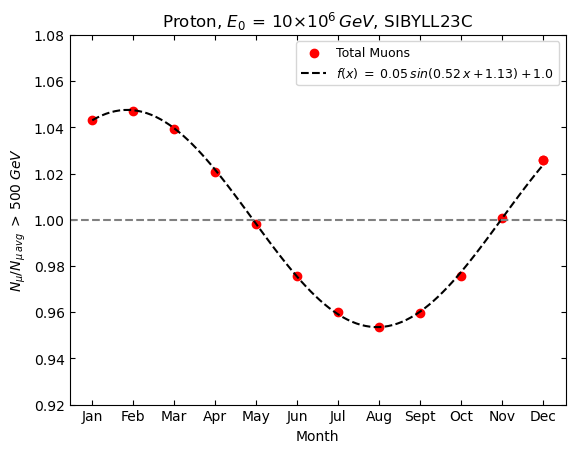

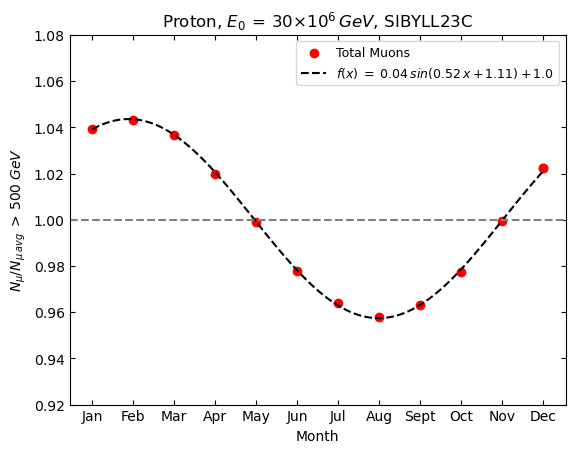

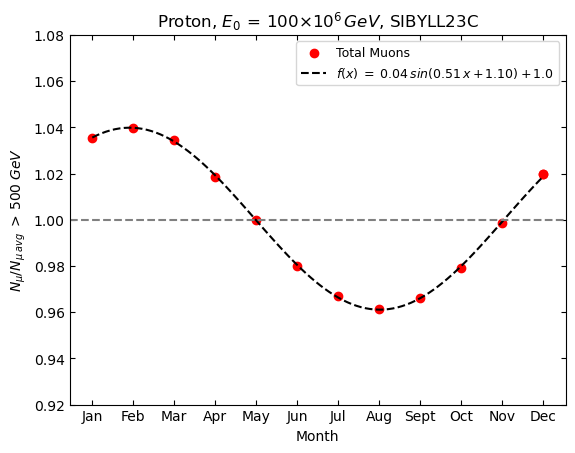

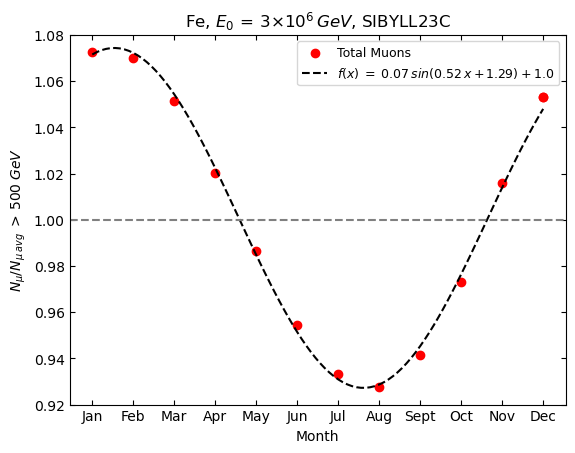

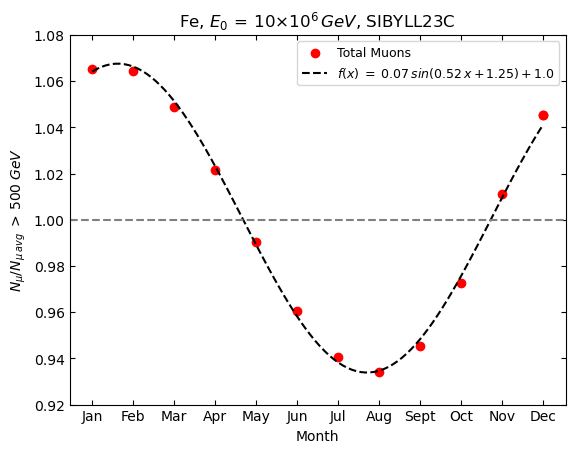

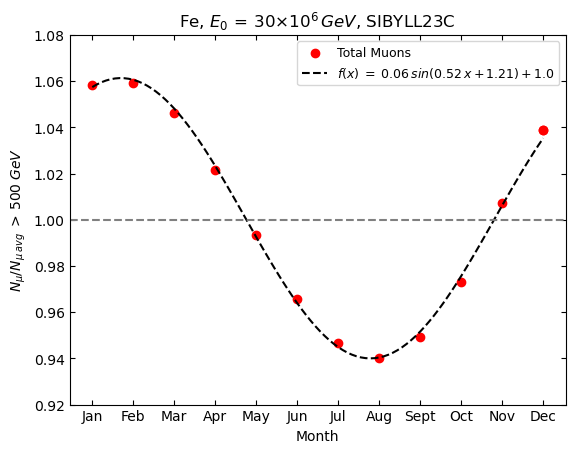

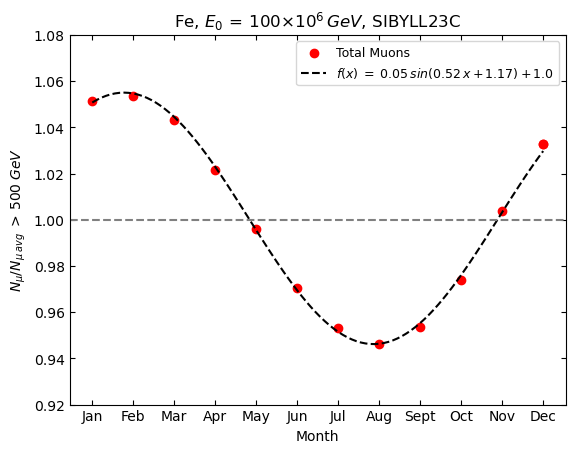

In [ ]:
with PdfPages('C:/Users/catal/IceCube Research/Sybyll23C/Fittings.pdf') as pdf:
    prime_energies = [3, 10, 30, 100] #PeV
    for particle in ['Proton', 'Fe']:
        for j in prime_energies:
            tot_mu, mu_pi, mu_k, mu_other = np.loadtxt('C:/Users/catal/IceCube Research/Sybyll23C/Muon_Sources\{}\{}PeV\Sums2.txt'.format(particle, j, j), unpack=True)
            mu_avg = sum(tot_mu)/12 # yearly average for total number of muons
            mu_pi_avg = sum(mu_pi)/12
            mu_k_avg = sum(mu_k)/12
            mu_other_avg = sum(mu_other)/12

            fig, ax = plt.subplots()
            for i in range(len(months)):
                plt.scatter(i, tot_mu[i]/mu_avg, c = 'r')
                if i == 11: 
                    plt.scatter(i, tot_mu[i]/mu_avg, c = 'r', label = 'Total Muons') 

            ## Fitting
            popt, pcov = curve_fit(sfit, [0,1,2,3,4,5,6,7,8,9,10,11], tot_mu/mu_avg, p0=[0.06, 1/6, 1, 1])
            print(popt)
            amplitude_fit, frequency_fit, phase_fit, offset_fit = popt
            x_fit = np.linspace(0, 11, 100)
            y_fit = sfit(x_fit, amplitude_fit, frequency_fit, phase_fit, offset_fit)
            plt.plot(x_fit, y_fit, '-', label='$f(x)\; =\;{:0.2f}\,sin({:0.2f}\,x + {:0.2f}) + {:0.1f}$'.format(amplitude_fit, frequency_fit, phase_fit, offset_fit), ls = '--', color = 'black')

            ###
            plt.axhline(y=1, color='grey', linestyle='--')
            #plt.legend()
            ax.tick_params(top=True, bottom=True, left=True, right=True, direction='in')
            plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], months_label)
            plt.ylim(0.92, 1.08)
            plt.xlabel('Month')
            plt.ylabel('$N_\mu / N_{\mu \; avg} \; > \, 500 \; GeV$')
            plt.title(particle + ', ' + '$E_0 \,=\,$' + str(j) + R'$ \times 10^6 \, GeV$' + ', SIBYLL23C')
            plt.legend(fontsize = 9)
        
            pdf.savefig()
    

#### EPOS-LHC Sinusoidal Fittings

[0.05432209 0.51592046 1.1577212  1.00061594]
[0.04891312 0.51546784 1.12808963 1.00057102]


C:\Users\catal\AppData\Local\Temp\ipykernel_21500\682718317.py:24: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x_fit, y_fit, '-', label='$f(x)\; =\;{:0.2f}\,sin({:0.2f}\,x + {:0.2f}) + {:0.1f}$'.format(amplitude_fit, frequency_fit, phase_fit, offset_fit), ls = '--', color = 'black')


[0.04460907 0.51510241 1.10848287 1.00053346]
[0.04061725 0.51479678 1.09447533 1.00049574]
[0.07666148 0.51720556 1.30493216 1.00081025]
[0.06985691 0.5169138  1.2588903  1.00074835]
[0.06345685 0.51657247 1.21576967 1.00069172]
[0.05691279 0.5161236  1.17344082 1.00063714]


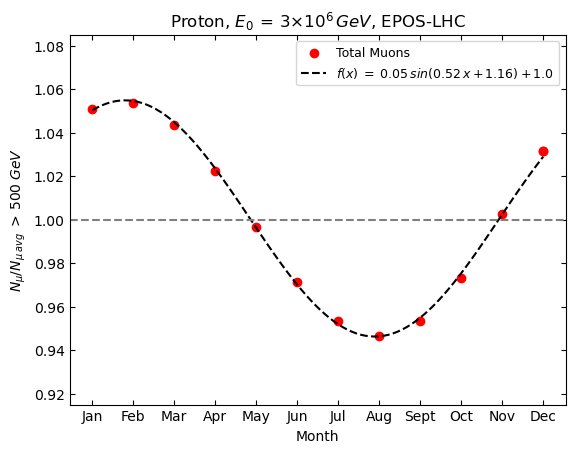

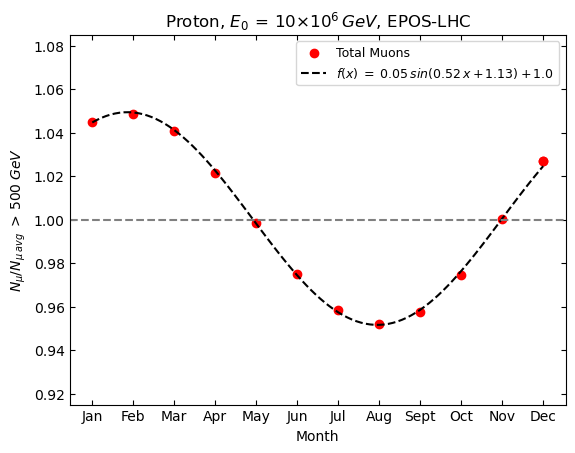

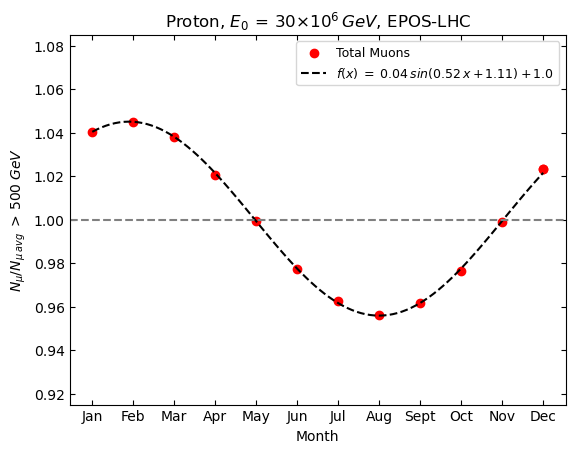

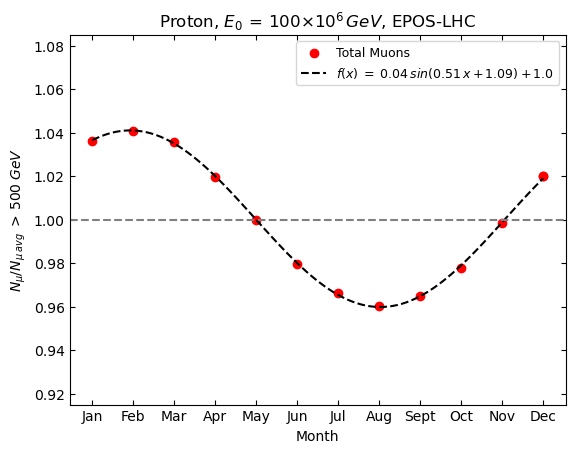

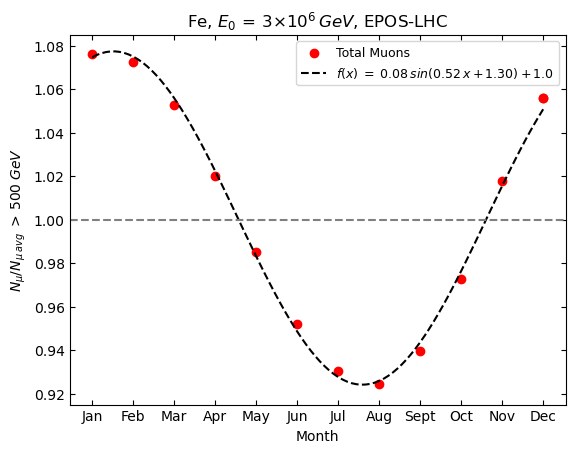

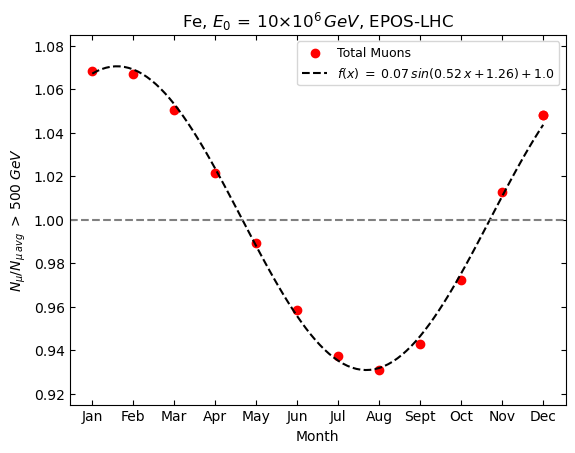

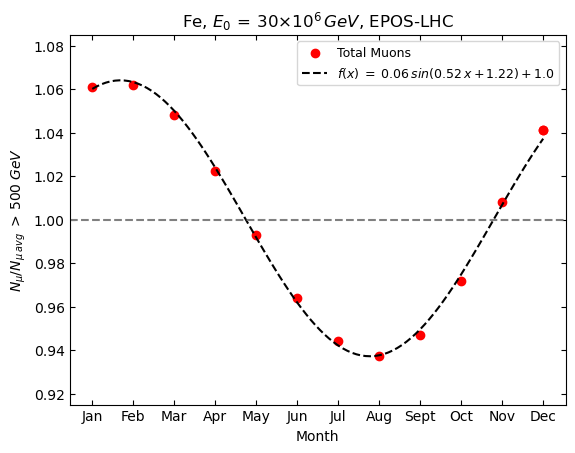

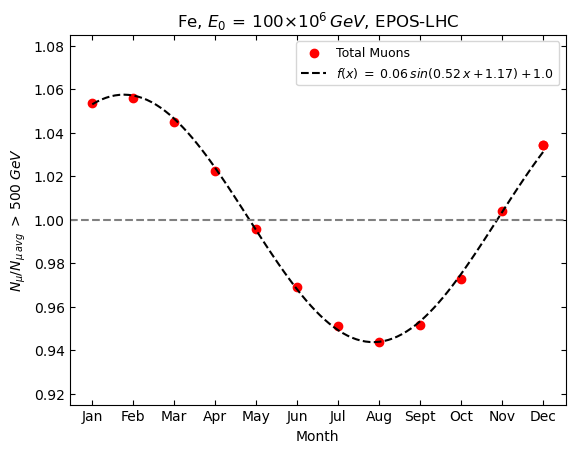

In [ ]:
with PdfPages('C:/Users/catal/IceCube Research/EPOS-LHC/Fittings.pdf') as pdf:
    prime_energies = [3, 10, 30, 100] #PeV
    
    for particle in ['Proton', 'Fe']:
        for j in prime_energies:
            tot_mu, mu_pi, mu_k, mu_other = np.loadtxt('C:/Users/catal/IceCube Research/EPOS-LHC/Muon_Sources\{}\{}PeV\Sums2.txt'.format(particle, j, j), unpack=True)
            mu_avg = sum(tot_mu)/12 # yearly average for total number of muons
            mu_pi_avg = sum(mu_pi)/12
            mu_k_avg = sum(mu_k)/12
            mu_other_avg = sum(mu_other)/12

            fig, ax = plt.subplots()
            for i in range(len(months)):
                plt.scatter(i, tot_mu[i]/mu_avg, c = 'r')
                if i == 11: 
                    plt.scatter(i, tot_mu[i]/mu_avg, c = 'r', label = 'Total Muons') 

            ## Fitting
            popt, pcov = curve_fit(sfit, [0,1,2,3,4,5,6,7,8,9,10,11], tot_mu/mu_avg, p0=[0.06, 1/6, 1, 1])
            print(popt)
            amplitude_fit, frequency_fit, phase_fit, offset_fit = popt
            x_fit = np.linspace(0, 11, 100)
            y_fit = sfit(x_fit, amplitude_fit, frequency_fit, phase_fit, offset_fit)
            plt.plot(x_fit, y_fit, '-', label='$f(x)\; =\;{:0.2f}\,sin({:0.2f}\,x + {:0.2f}) + {:0.1f}$'.format(amplitude_fit, frequency_fit, phase_fit, offset_fit), ls = '--', color = 'black')

            ###
            plt.axhline(y=1, color='grey', linestyle='--')
            #plt.legend()
            ax.tick_params(top=True, bottom=True, left=True, right=True, direction='in')
            plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], months_label)
            plt.ylim(0.915, 1.085)
            plt.xlabel('Month')
            plt.ylabel('$N_\mu / N_{\mu \; avg} \; > \, 500 \; GeV$')
            plt.title(particle + ', ' + '$E_0 \,=\,$' + str(j) + R'$ \times 10^6 \, GeV$' + ', EPOS-LHC')
            plt.legend(fontsize = 9)
        
            pdf.savefig()
        

#### QGSJet-II-04 Sinusoidal Fittings

[0.05486644 0.51594933 1.15872893 1.00062037]


C:\Users\catal\AppData\Local\Temp\ipykernel_3068\2360589971.py:24: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x_fit, y_fit, '-', label='$f(x)\; =\;{:0.2f}\,sin({:0.2f}\,x + {:0.2f}) + {:0.1f}$'.format(amplitude_fit, frequency_fit, phase_fit, offset_fit), ls = '--', color = 'black')


[0.04998525 0.51553342 1.13141727 1.00058074]
[0.04620458 0.51520104 1.11335283 1.00054889]
[0.04258075 0.51489705 1.09918407 1.00051639]
[0.07613078 0.5172575  1.30152794 1.00079646]
[0.06962016 0.51693389 1.2565248  1.00074237]
[0.06339098 0.51657473 1.21376431 1.00068971]
[0.05722643 0.51613777 1.17324781 1.00063936]


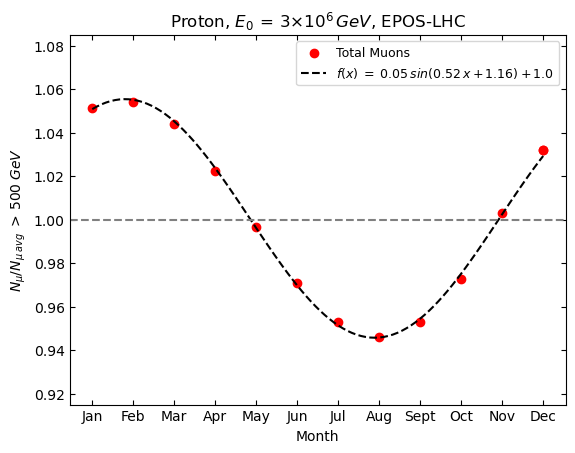

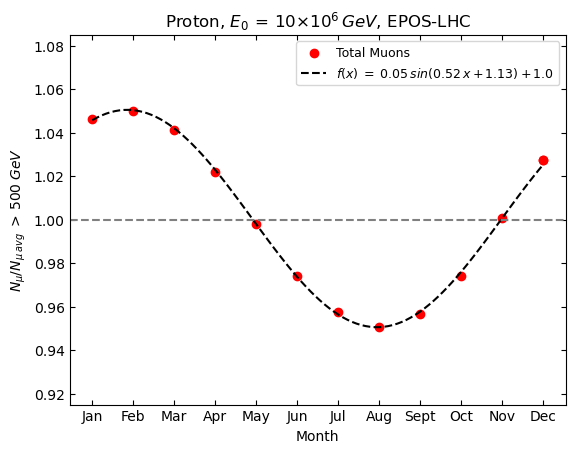

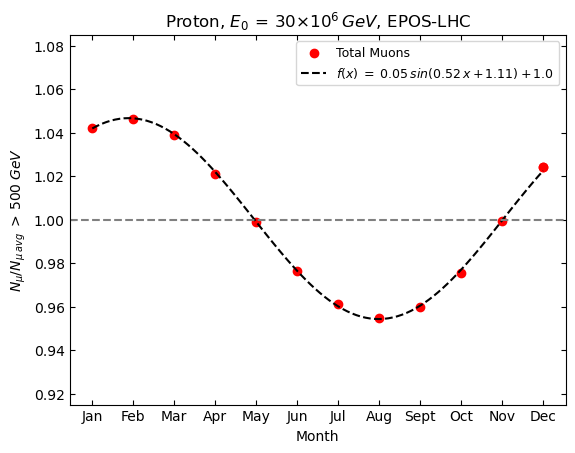

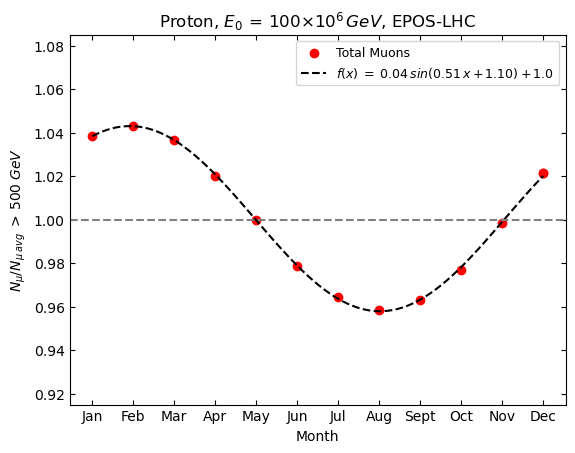

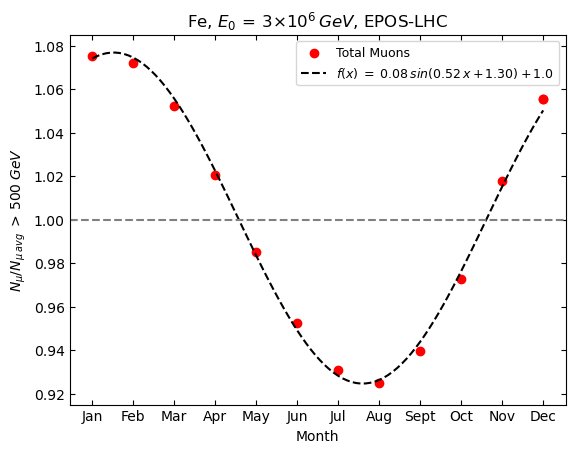

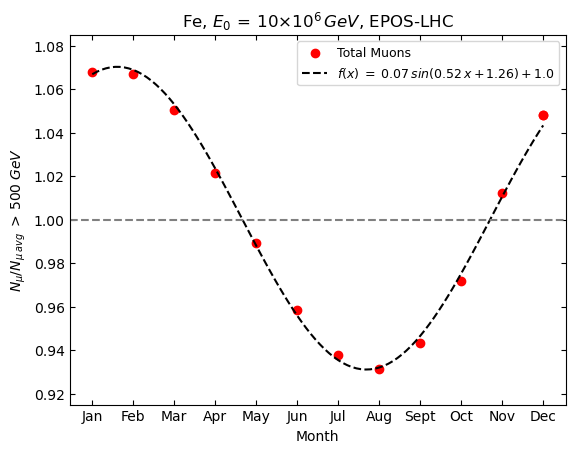

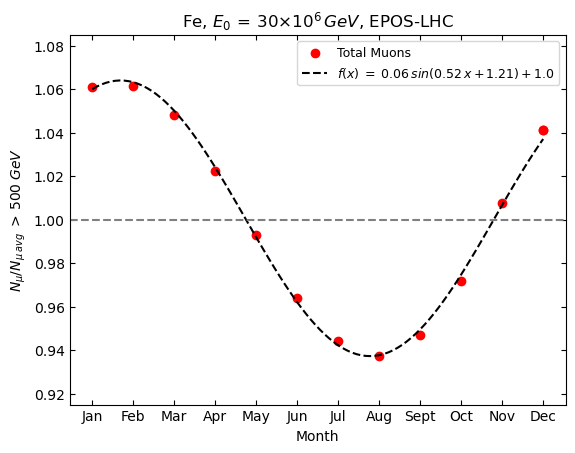

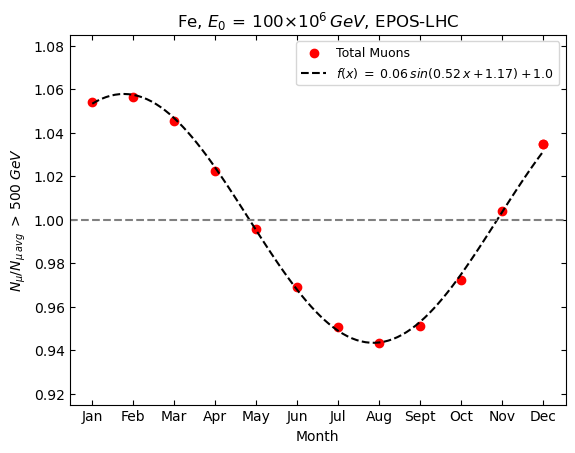

In [ ]:
with PdfPages('C:/Users/catal/IceCube Research/QGSJet-II-04/Fittings.pdf') as pdf:
    prime_energies = [3, 10, 30, 100] #PeV
    
    for particle in ['Proton', 'Fe']:
        for j in prime_energies:
            tot_mu, mu_pi, mu_k, mu_other = np.loadtxt('C:/Users/catal/IceCube Research/QGSJet-II-04/Muon_Sources\{}\{}PeV\Sums2.txt'.format(particle, j, j), unpack=True)
            mu_avg = sum(tot_mu)/12 # yearly average for total number of muons
            mu_pi_avg = sum(mu_pi)/12
            mu_k_avg = sum(mu_k)/12
            mu_other_avg = sum(mu_other)/12

            fig, ax = plt.subplots()
            for i in range(len(months)):
                plt.scatter(i, tot_mu[i]/mu_avg, c = 'r')
                if i == 11: 
                    plt.scatter(i, tot_mu[i]/mu_avg, c = 'r', label = 'Total Muons') 

            ## Fitting
            popt, pcov = curve_fit(sfit, [0,1,2,3,4,5,6,7,8,9,10,11], tot_mu/mu_avg, p0=[0.06, 1/6, 1, 1])
            print(popt)
            amplitude_fit, frequency_fit, phase_fit, offset_fit = popt
            x_fit = np.linspace(0, 11, 100)
            y_fit = sfit(x_fit, amplitude_fit, frequency_fit, phase_fit, offset_fit)
            plt.plot(x_fit, y_fit, '-', label='$f(x)\; =\;{:0.2f}\,sin({:0.2f}\,x + {:0.2f}) + {:0.1f}$'.format(amplitude_fit, frequency_fit, phase_fit, offset_fit), ls = '--', color = 'black')

            ###
            plt.axhline(y=1, color='grey', linestyle='--')
            #plt.legend()
            ax.tick_params(top=True, bottom=True, left=True, right=True, direction='in')
            plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], months_label)
            plt.ylim(0.915, 1.085)
            plt.xlabel('Month')
            plt.ylabel('$N_\mu / N_{\mu \; avg} \; > \, 500 \; GeV$')
            plt.title(particle + ', ' + '$E_0 \,=\,$' + str(j) + R'$ \times 10^6 \, GeV$' + ', EPOS-LHC')
            plt.legend(fontsize = 9)
        
            pdf.savefig()
        